In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pandas_datareader import data as wb

In [2]:
data=pd.DataFrame()
stocks = ['RELIANCE.NS', 'KOTAKBANK.NS', 'TCS.NS', 'HINDUNILVR.NS']
for stock in stocks:
    data[stock] = wb.DataReader(stock, data_source = 'yahoo', start = '2015-1-1')['Adj Close']

In [3]:
data

,RELIANCE.NS,KOTAKBANK.NS,TCS.NS,HINDUNILVR.NS
Date,,,,
2015-01-01,419.247314,627.093628,1112.774170,679.404358
2015-01-02,418.137726,633.545959,1127.593018,677.164978
2015-01-05,413.557587,631.004822,1110.457153,681.061523
2015-01-06,394.788544,623.481323,1069.518188,693.960815
2015-01-07,403.382172,633.520996,1056.884766,718.326050
...,...,...,...,...
2021-10-27,2627.399902,2188.250000,3489.750000,2396.600098
2021-10-28,2598.600098,2098.500000,3421.649902,2389.649902
2021-10-29,2536.250000,2031.150024,3397.750000,2393.149902


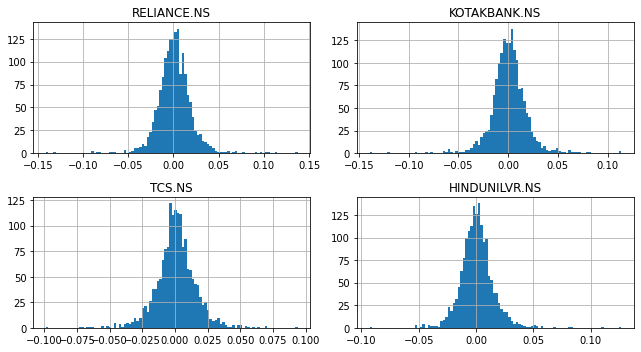

In [16]:
log_ret = np.log(data/data.shift(1))
log_ret.hist(bins=100,figsize=(9,5))
plt.tight_layout()

In [6]:
log_ret.mean()*252

RELIANCE.NS      0.267249
KOTAKBANK.NS     0.179186
TCS.NS           0.170801
HINDUNILVR.NS    0.190025
dtype: float64

In [7]:
log_ret.cov()*252

,RELIANCE.NS,KOTAKBANK.NS,TCS.NS,HINDUNILVR.NS
RELIANCE.NS,0.087904,0.030191,0.019282,0.019478
KOTAKBANK.NS,0.030191,0.078674,0.014999,0.019011
TCS.NS,0.019282,0.014999,0.061174,0.013724
HINDUNILVR.NS,0.019478,0.019011,0.013724,0.054617


In [8]:
log_ret.corr()

,RELIANCE.NS,KOTAKBANK.NS,TCS.NS,HINDUNILVR.NS
RELIANCE.NS,1.000000,0.363047,0.262942,0.281108
KOTAKBANK.NS,0.363047,1.000000,0.216209,0.290023
TCS.NS,0.262942,0.216209,1.000000,0.237430
HINDUNILVR.NS,0.281108,0.290023,0.237430,1.000000


**METHOD 1 TO FIND EFFICIENT FRONTIER AND WEIGHTS**

In [39]:
np.random.seed(101)

num_ports = 2000
all_weights = np.zeros((num_ports,len(data.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)
rf = 0.05

for ind in range(num_ports):
    weights = np.array(np.random.random(len(data.columns)))
    weights /=np.sum(weights)
    all_weights[ind,:] = weights
    
    ret_arr[ind] = np.sum((log_ret.mean() * weights) * 252)
    
    vol_arr[ind] = np.sqrt(np.dot(weights.T , np.dot(log_ret.cov()*252 , weights)))
    
    sharpe_arr[ind] = (ret_arr[ind] - rf)/vol_arr[ind]


In [40]:
sharpe_arr.max()

0.8783842683359321

In [41]:
all_weights[sharpe_arr.argmax(),:]

array([0.36993849, 0.08223786, 0.21564491, 0.33217874])

In [42]:
max_sr_ret = ret_arr[sharpe_arr.argmax()]
max_sr_vol = vol_arr[sharpe_arr.argmax()]

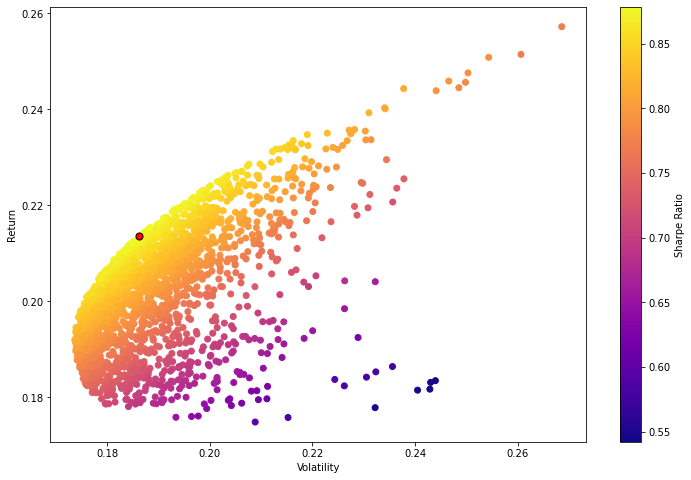

In [43]:
#Plotting above result
plt.figure(figsize=(12,8))
plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

# Add red dot for max SR
plt.scatter(max_sr_vol,max_sr_ret,c='red',s=50,edgecolors='black')

**METHOD 2 TO FIND EFFICIENT FRONTIER AND OPTIMAL WEIGHTS**

In [45]:
from scipy.optimize import minimize

In [47]:
help(minimize)

Help on function minimize in module scipy.optimize._minimize:

minimize(fun, x0, args=(), method=None, jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None)
    Minimization of scalar function of one or more variables.
    
    Parameters
    ----------
    fun : callable
        The objective function to be minimized.
    
            ``fun(x, *args) -> float``
    
        where ``x`` is an 1-D array with shape (n,) and ``args``
        is a tuple of the fixed parameters needed to completely
        specify the function.
    x0 : ndarray, shape (n,)
        Initial guess. Array of real elements of size (n,),
        where 'n' is the number of independent variables.
    args : tuple, optional
        Extra arguments passed to the objective function and its
        derivatives (`fun`, `jac` and `hess` functions).
    method : str or callable, optional
        Type of solver.  Should be one of
    
            - 'Nelder-Mead' :ref:`(see her

In [49]:
def get_ret_vol_sr(weights):
    """
    Takes in weights, returns array or return,volatility, sharpe ratio
    """
    rf=0.05
    weights = np.array(weights)
    ret = np.sum(log_ret.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))
    sr = (ret-rf)/vol
    return np.array([ret,vol,sr])

In [66]:
#below are some input parameters required for minimize function

#Optimization works as a minimization function, since we actually want to maximize the Sharpe Ratio, 
#we will need to turn it negative so we can minimize the negative sharpe 
#(same as maximizing the postive sharpe)
def neg_sharpe(weights):
    return  get_ret_vol_sr(weights)[2] * -1


#constraint 
def check_sum(weights):
    '''
    Returns 0 if sum of weights is 1.0
    '''
    return np.sum(weights) - 1

# By convention of minimize function it should be a function that returns zero for conditions
cons = ({'type':'eq','fun': check_sum})


# 0 to 1 bounds for each weight if long only portfolio; -1 to 1 bounds if long+short portfolio
bounds = ((-1, 1), (-1, 1), (-1, 1), (-1, 1))


# Initial Guess (equal distribution)
init_guess = [0.25,0.25,0.25,0.25]

In [76]:
# Sequential Least SQuares Programming (SLSQP) - goto documentation of minimize for more info.
opt_results = minimize(neg_sharpe,init_guess,method='SLSQP',bounds=bounds,constraints=cons)

In [68]:
opt_results

     fun: -0.8785057207036613
     jac: array([-0.26705267, -0.26689318, -0.26736258, -0.26734314])
 message: 'Optimization terminated successfully'
    nfev: 25
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.37889187, 0.08563998, 0.20622898, 0.32923916])

In [69]:
opt_results.x

array([0.37889187, 0.08563998, 0.20622898, 0.32923916])

In [75]:
get_ret_vol_sr(opt_results.x)
print('return =', round(get_ret_vol_sr(opt_results.x)[0] * 100, 2), '%')
print('volatility =', round(get_ret_vol_sr(opt_results.x)[1] * 100, 2), '%')
print('sharpe ratio =', round(get_ret_vol_sr(opt_results.x)[2], 4))

return = 21.44 %
volatility = 18.71 %
sharpe ratio = 0.8785


Plotting Efficient frontier line
Previously we minimized negetive sharpe ratio(so as to maximize sharpe ratio)
Now, we will minimize Volatility

In [80]:
#To minimize volatility-
def minimize_volatility(weights):
    return  get_ret_vol_sr(weights)[1]

In [86]:
# Our returns go from 0 to somewhere along 0.3
# Create a linspace number of points to calculate x on since our efficient frontier is a line so 
#we need many points to plot the line and also we would need a for loop for calc each point
frontier_y = np.linspace(0.15,0.26,100)

In [87]:
frontier_volatility = [] #to store the line 

for possible_return in frontier_y:
    # function for return
    cons = ({'type':'eq','fun': check_sum},
            {'type':'eq','fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})
    
    result = minimize(minimize_volatility,init_guess,method='SLSQP',bounds=bounds,constraints=cons)
    
    frontier_volatility.append(result['fun'])

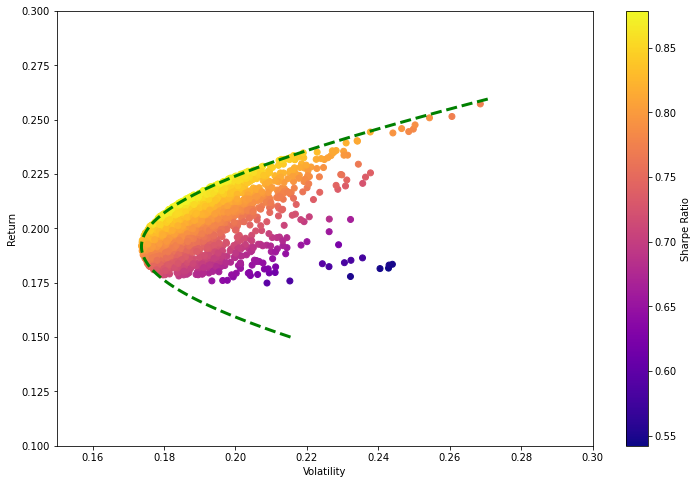

In [88]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.xlim([0.15,0.3])
plt.ylim([0.10,0.30])


# Add frontier line
plt.plot(frontier_volatility,frontier_y,'g--',linewidth=3)